Miles Voenell Coding Assignment #2 11/1/24

In [ ]:
#2D from HW1------------- Q1-2 in HW2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, color
import os
import glob
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
 
def get_image(annot):
    img_path = '../DataMining/Cropped/'
    file = annot.split('ion')
    img_filename = img_path +file[-1]+'-0.jpg'
    return img_filename  

dog_images = glob.glob('../DataMining/DogImages/*/*')
annotations = glob.glob('../DataMining/Annotation/*/*')
histograms = []
for i in range(len(annotations)):
    dog = get_image(annotations[i])
    image = io.imread(dog)
    image = color.rgb2gray(image)
    edges = filters.sobel(image)
    gradient_x = filters.sobel_h(image)
    gradient_y = filters.sobel_v(image)
    edge_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    edge_orientation = np.arctan2(gradient_y, gradient_x)
    num_bins = 36
    histogram, bin_edges = np.histogram(np.degrees(edge_orientation), bins=num_bins, range=(-180, 180), weights=edge_magnitude)
    histogram = histogram / np.sum(histogram)
    histograms.append(histogram)
    
histograms_array = np.array(histograms)


In [44]:
#Q3-5
from sklearn.model_selection import train_test_split

# Class: 0 for Border Terrier, 1 for Wire-haired Fox Terrier, 2 for Pembroke, 3 for Dhole
y = np.array([0]*171 + [1]*157 + [2]*181 + [3]*(len(histograms_array) - 171 - 157 - 181))
X_train, X_test, y_train, y_test = train_test_split(histograms_array, y, test_size=0.2, stratify=y, random_state=42)

#size
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

#split maintains class distribution
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

print("Class distribution in training set:", dict(zip(unique_train, counts_train)))
print("Class distribution in test set:", dict(zip(unique_test, counts_test)))

#StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Mean and SD
print("Mean of scaled training data (should be close to 0):", np.mean(X_train_scaled))
print("Standard deviation of scaled training data (should be close to 1):", np.std(X_train_scaled))


Training set size: 528
Test set size: 132
Class distribution in training set: {0: 137, 1: 125, 2: 145, 3: 121}
Class distribution in test set: {0: 34, 1: 32, 2: 36, 3: 30}
Mean of scaled training data (should be close to 0): -6.339859426815708e-16
Standard deviation of scaled training data (should be close to 1): 0.9999999999999999


#Q6
#Naïve Bayes, Decision Tree,Random Forest Classifier
#used a bit of code from these links

https://www.kaggle.com/code/satishgunjal/tutorial-k-fold-cross-validation#K-Fold:-Regression-Example-

Satishgunjal. “Tutorial: K Fold Cross Validation.” Kaggle, Kaggle, 6 Dec. 2020, 
    www.kaggle.com/code/satishgunjal/tutorial-k-fold-cross-validation#K-Fold:-Regression-Example-. 

https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/

“Cross-Validation Using K-Fold with Scikit-Learn.” GeeksforGeeks, GeeksforGeeks, 27 May 2024, 
    www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/. 

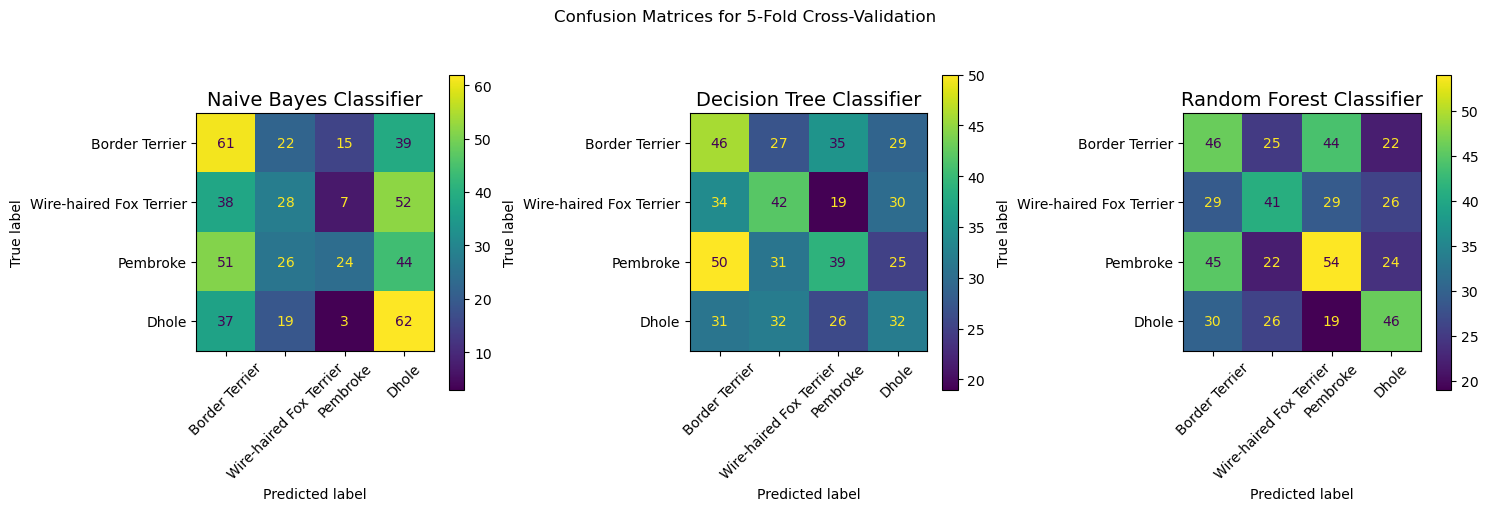

In [ ]:

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize
classifiers = {
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

#5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Plot setup
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Confusion Matrices for 5-Fold Cross-Validation")

#compute confusion matrices
for idx, (name, classifier) in enumerate(classifiers.items()):
    y_pred = cross_val_predict(classifier, X_train_scaled, y_train, cv=skf)
    cm = confusion_matrix(y_train, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Border Terrier", "Wire-haired Fox Terrier", "Pembroke", "Dhole"])
    disp.plot(ax=axes[idx], cmap='viridis')
    #Label nonsense so they do not overlap
    axes[idx].set_title(f"{name} Classifier", fontsize=14)
    for label in axes[idx].get_xticklabels():
        label.set_rotation(45)
        label.set_size(10) 
    for label in axes[idx].get_yticklabels():
        label.set_size(10)
    axes[idx].tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



I think that random forest looks like the best method because the values are clearly highest for the correct predictions down the middle of the graph.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score

# Compute cross-validation accuracies
nb_scores = cross_val_score(GaussianNB(), X_train_scaled, y_train, cv=5)
dt_scores = cross_val_score(DecisionTreeClassifier(random_state=42), X_train_scaled, y_train, cv=5)
rf_scores = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), X_train_scaled, y_train, cv=5)

print("Naive Bayes Mean CV Accuracy:", nb_scores.mean())
print("Decision Tree Mean CV Accuracy:", dt_scores.mean())
print("Random Forest Mean CV Accuracy:", rf_scores.mean())

# Compute accuracies
nb_classifier = GaussianNB().fit(X_train_scaled, y_train)
dt_classifier = DecisionTreeClassifier(random_state=42).fit(X_train_scaled, y_train)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train_scaled, y_train)

nb_accuracy = accuracy_score(y_test, nb_classifier.predict(X_test_scaled))
dt_accuracy = accuracy_score(y_test, dt_classifier.predict(X_test_scaled))
rf_accuracy = accuracy_score(y_test, rf_classifier.predict(X_test_scaled))

print("Naive Bayes Test Accuracy:", nb_accuracy)
print("Decision Tree Test Accuracy:", dt_accuracy)
print("Random Forest Test Accuracy:", rf_accuracy)

# Compute F-measure
nb_f1 = f1_score(y_test, nb_classifier.predict(X_test_scaled), average='macro')
dt_f1 = f1_score(y_test, dt_classifier.predict(X_test_scaled), average='macro')
rf_f1 = f1_score(y_test, rf_classifier.predict(X_test_scaled), average='macro')

print("Naive Bayes F1 Score:", nb_f1)
print("Decision Tree F1 Score:", dt_f1)
print("Random Forest F1 Score:", rf_f1)


Naive Bayes Mean CV Accuracy: 0.3427493261455526
Decision Tree Mean CV Accuracy: 0.2935130278526505
Random Forest Mean CV Accuracy: 0.36172506738544474
Naive Bayes Test Accuracy: 0.2803030303030303
Decision Tree Test Accuracy: 0.29545454545454547
Random Forest Test Accuracy: 0.30303030303030304
Naive Bayes F1 Score: 0.2481380925290042
Decision Tree F1 Score: 0.29583054812834225
Random Forest F1 Score: 0.29945857528210196


Based on the accuracies the Random forest is the best method at 36.1% accurate. It is also has the highest accuracy on the test set and the highest F measure. 

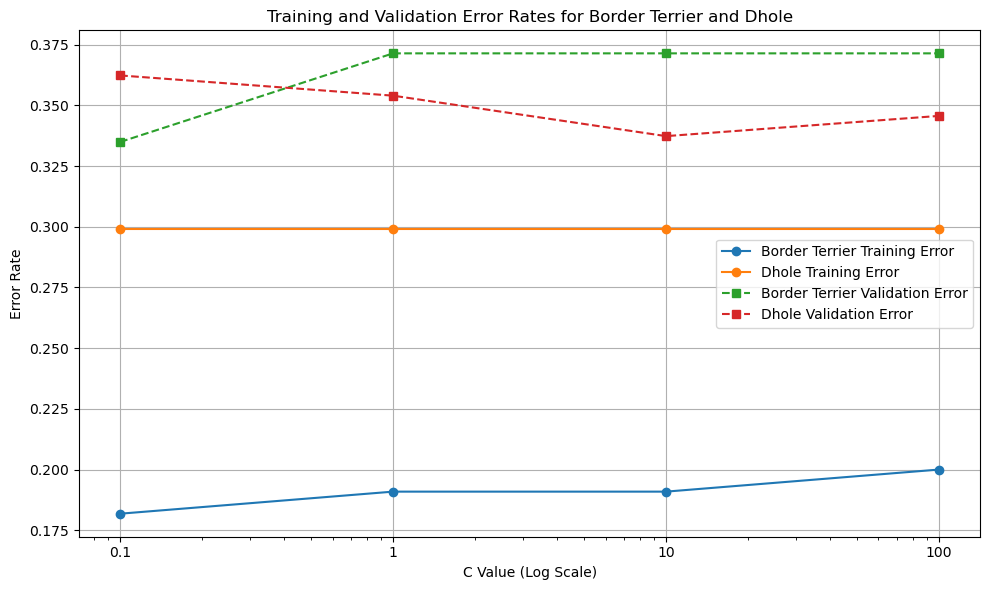

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
#“Validation Curve.” GeeksforGeeks, 29 May 2023, www.geeksforgeeks.org/validation-curve/. 
#“Understanding Scikit-Learn’s SVC: Decision Function and Predict.” GeeksforGeeks, GeeksforGeeks, 19 Aug. 2024, www.geeksforgeeks.org/understanding-scikit-learns-svc-decision-function-and-predict/. 
#only Border Terrier (class 0) and Dhole (class 3) data
mask = (y_train == 0) | (y_train == 3)
X_train_filtered = X_train_scaled[mask]
y_train_filtered = y_train[mask]
C_values = [0.1, 1, 10, 100]
train_results_BT = {}
train_results_DH = {}
val_results_BT = {}
val_results_DH = {}
train_error_BT = {}
train_error_DH = {}
validation_error_border_terrier = {}
validation_error_dhole = {}

#cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for C in C_values:
    model = LinearSVC(C=C, max_iter=10000, random_state=42, dual=False)
    val_accuracies_BT = []
    val_accuracies_DH = []
    
    #cross-validation
    for train_index, val_index in skf.split(X_train_filtered, y_train_filtered):
        X_train_fold, X_val = X_train_filtered[train_index], X_train_filtered[val_index]
        y_train2, Y_val = y_train_filtered[train_index], y_train_filtered[val_index]
        model.fit(X_train_fold, y_train2)
        
        #training accuracy
        train_acc_BT = model.score(X_train_fold[y_train2 == 0], y_train2[y_train2 == 0])
        train_acc_DH = model.score(X_train_fold[y_train2 == 3], y_train2[y_train2 == 3])
        
        #validation accuracy
        val_acc_BT = model.score(X_val[Y_val == 0], Y_val[Y_val == 0])
        val_acc_DH = model.score(X_val[Y_val == 3], Y_val[Y_val == 3])
        
        #training and validation accuracies
        train_results_BT[C] = train_acc_BT
        train_results_DH[C] = train_acc_DH
        val_accuracies_BT.append(val_acc_BT)
        val_accuracies_DH.append(val_acc_DH)

    #mean validation accuracy
    val_results_BT[C] = np.mean(val_accuracies_BT)
    val_results_DH[C] = np.mean(val_accuracies_DH)

    #training error rates
    train_error_BT[C] = 1 - train_results_BT[C]
    train_error_DH[C] = 1 - train_results_DH[C]
    
    #validation error rates
    validation_error_border_terrier[C] = 1 - val_results_BT[C]
    validation_error_dhole[C] = 1 - val_results_DH[C]


plt.figure(figsize=(10, 6))
plt.plot(C_values, [train_error_BT[C] for C in C_values], marker='o', label='Border Terrier Training Error', linestyle='-')
plt.plot(C_values, [train_error_DH[C] for C in C_values], marker='o', label='Dhole Training Error', linestyle='-')
plt.plot(C_values, [validation_error_border_terrier[C] for C in C_values], marker='s', label='Border Terrier Validation Error', linestyle='--')
plt.plot(C_values, [validation_error_dhole[C] for C in C_values], marker='s', label='Dhole Validation Error', linestyle='--')

plt.xscale('log')
plt.xticks(C_values, C_values)
plt.xlabel('C Value (Log Scale)')
plt.ylabel('Error Rate')
plt.title('Training and Validation Error Rates for Border Terrier and Dhole')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


For border terrier the training error is lowest at c = 0.1 while the training error for Dhole is constant accross c values. Border terrier has the lowest validation error at c = 0.1 while Dhole has the lowest validation error at c = 10. A lower C value supports a more simple model that may have margin violation. While a higher C tries to reduce training error but risks overfitting. Since Dhole has a constant training error which means over and underfitting are unlikely in that case. For border terrier there is a risk of underfitting because the training error is low but the validation error is high. 

In [60]:
best_C = min(validation_error_border_terrier, key=validation_error_border_terrier.get)

best_model = LinearSVC(C=best_C, max_iter=10000, random_state=42, dual=False)
best_model.fit(X_train_filtered, y_train_filtered)

mask_test = (y_test == 0) | (y_test == 3)
X_test_filtered = X_test_scaled[mask_test]
y_test_filtered = y_test[mask_test]

test_accuracy = best_model.score(X_test_filtered, y_test_filtered)
test_error = 1 - test_accuracy

print(f"Best C value: {best_C}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test error rate: {test_error:.4f}")


Best C value: 0.1
Test accuracy: 0.5625
Test error rate: 0.4375
